# Test Controlled SMC

Test Controlled SMC algorithm on Stochastic Volatiliy Model

For more details on ControlledSMC models and their properties, see the article: https://arxiv.org/abs/1708.08396

Steps to define a ControlledSMC model: 
Step 1 : - Define your own model (for example a state space model [See basic tutorial lesson]). 
           This model should be an ssm object. For example: ssm = stovolModel() 
         - Define your own policy functions. 
         
Step 2 :  Create the ControlledSMC object as follow:
     myCtrlSMC = cSMC.ControlledSMC(ssm=stovolModel, data = data, iterations = 5)
       ssm = your original defined model 
       data: is your data
       iterations = fixed at your convenience. 

 
## First steps: defining a state-space model and Policy functionss

We start by importing some standard libraries, plus some modules from the package.

In [16]:
%matplotlib inline
import warnings; warnings.simplefilter('ignore')  # hide warnings 

# standard libraries
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sb
from particles import distributions as dists  # where probability distributions are defined
from particles import state_space_models as ssm  # where state-space models are defined
from particles.collectors import Moments  
from collectors import Moments 
from sklearn.linear_model import Ridge
import controlled_smc as cSMC


Let's define our first state-space model **class** and the policy function. We consider a basic stochastic volalitility model, that is: 
\begin{align*}
X_0 & \sim N\left(\mu, \frac{\sigma^2}{1-\rho^2}\right), &\\
X_t|X_{t-1}=x_{t-1} & \sim N\left( \mu + \rho (x_{t-1}-\mu), \sigma^2\right), &\quad t\geq 1, \\
Y_t|X_t=x_t & \sim N\left(0, e^{x_t}\right),& \quad t\geq 0.
\end{align*}
 
Note that this model depends on fixed parameter $\theta=(\mu, \rho, \sigma)$. The policy function P is defined as:

$$
\log P_t(t, X_{t-1}, X_{t})   =  -[(A_t X_{t},X_{t}) + (B_t,X_{t}) + c_t]  
$$

In [34]:
#  DEFINE STOCHASTIC VOLATILITY MODEL
# ----------------------------------- 
class StochVol(ssm.StateSpaceModel):  
    """ """
    mu =  -1.0; sigma = 1.0; rho = 1.0/np.sqrt(2) #
    def PX0(self):  # Distribution of X_0
      """ """
      return  dists.Normal( loc = self.mu, scale=self.sigma / np.sqrt(1.0 - self.rho**2))
    def PX(self, t, xp):  # Distribution of X_t given X_{t-1}=xp (p=past)
        """ """
        return  dists.Normal(loc=self.mu + self.rho * (xp - self.mu), scale=self.sigma)
    def PY(self, t, xp, x): # Distribution of Y_t given X_t=x (and possibly X_{t-1}=xp)
        """ """
        return dists.Normal(loc=0., scale=np.exp(0.5*x))
    def policy(self,t): # a quadratic function  policy(At, Bt, Ct)
        """ return only coefs of the quadratic from of the policy function (A,B,c)
            log(policy(t, xp, x)) =  -[(A_t x,x) + (B_t,x) + c_t] - F(xp); where  A_t is a matrix dxd, B_t a d-vector, c_t a scalar  
        """
        return   0.002175129155947095,   0.021869510847052914,   0.53135057055622562

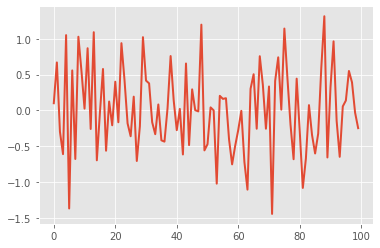

In [35]:
N = 100
# define the model
stovolModel = StochVol() 
true_states, data = stovolModel.simulate(N)  # we simulate from the model 100 data points

my_model = StochVol(mu=-1., rho=.9, sigma=.1)  # actual model with params
true_states, data = my_model.simulate(100)  # we simulate from the model 100 data points

plt.style.use('ggplot')
plt.figure()
plt.plot(data, linewidth = 2)


#  Twisted feynman kac model and bootstraap - simulations  comparison  

 


In [36]:
fk_StoVolTwisted  = cSMC.TwistedFK(ssm=stovolModel, data=data)  
fk_StoVolBootstrap= ssm.Bootstrap(ssm=stovolModel, data=data)   

# Bootstrap
pfBootstrap = particles.SMC(fk=fk_StoVolBootstrap, N=N, resampling='multinomial', collect=[Moments()], store_history=True)  
pfBootstrap.run()  # actual computation

# Twisted FK
pfTwisted =  particles.SMC(fk=fk_StoVolTwisted, N=N, resampling='multinomial', collect=[Moments()], store_history=True)
pfTwisted.run()  # actual computation

## Particle Smoothing

 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


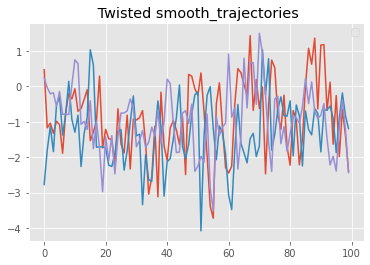

In [37]:

smooth_trajectories = pfTwisted.hist.backward_sampling(3) # 10 Trajectories
plt.figure()
plt.plot(smooth_trajectories)
plt.title(" Twisted smooth_trajectories")
plt.legend()

# results =  multiSMC(fk=fk_StoVolTwisted, N=100, nruns=30, qmc={'SMC':False, 'SQMC':True})
# plt.figure()
# sb.boxplot(x=[r['output'].logLt for r in results], y=[r['qmc'] for r in results]);

## Weights Distributions

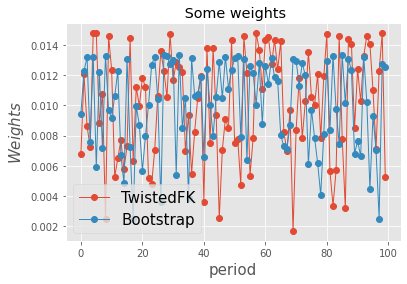

In [38]:
# A Serie of Weights # Make histogram
plt.figure()
plt.plot(np.arange(len(data)),   pfTwisted.W, linewidth = 1, marker = 'o') #  lineStyle = '.')
plt.plot(np.arange(len(data)),  pfBootstrap.W ,linewidth = 1, marker = 'o') 
plt.xlabel('period', fontsize = 15)
plt.ylabel('$Weights$', fontsize = 15)
plt.title(" Some weights")
plt.legend(['TwistedFK', 'Bootstrap'], fontsize = 15)

## Controlled smc - Feynman kac model  results


In [22]:
PsiSMC = cSMC.ControlledSMC(ssm=stovolModel, data = data, iterations = 10) 

PsiSMCResults = PsiSMC.RunAll()   


## TODO

 -
 -
 

